## Cài đặt thư viện

In [4]:
import os
import librosa
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

### Hiển thị tập dữ liệu

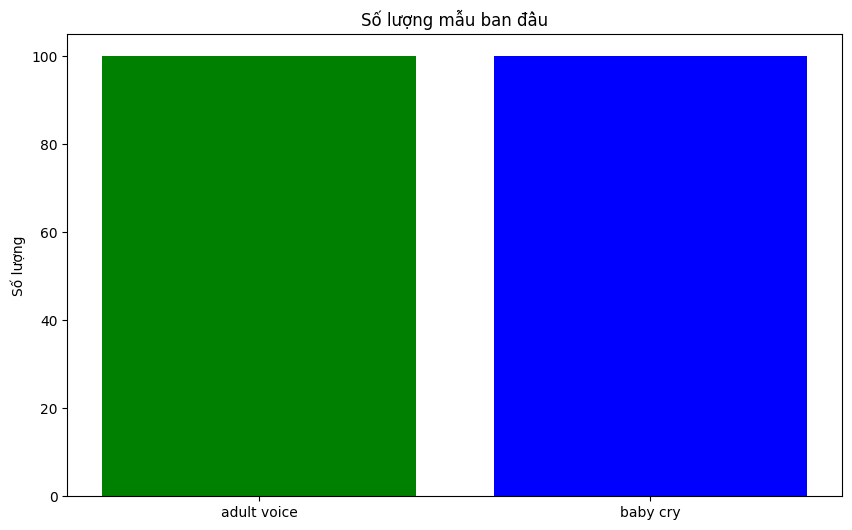

In [5]:
dataset_dir = 'data'
# Đếm số lượng file trong mỗi thư mục (ứng với mỗi class)
class_counts = {}
for class_folder in os.listdir(dataset_dir):
    class_path = os.path.join(dataset_dir, class_folder)
    if os.path.isdir(class_path):
        num_files = len(os.listdir(class_path))
        class_counts[class_folder] = num_files

# Vẽ biểu đồ cột
labels = list(class_counts.keys())
counts = list(class_counts.values())
colors = ['green', 'blue']
plt.figure(figsize=(10, 6))
plt.bar(labels, counts, color=colors)

plt.ylabel('Số lượng')
plt.title('Số lượng mẫu ban đầu')
plt.show()

### 1. Tiền xử lý dữ liệu

In [6]:
baby_cry_path = 'data/baby cry'
adult_voice_path = 'data/adult voice'

# Hàm chuẩn hóa độ dài tín hiệu âm thanh về 7 giây
def normalize_audio_length(y, sr, target_duration=7):
    target_length = int(sr * target_duration)
    
    if len(y) > target_length:
        # Nếu tín hiệu dài hơn 7s, cắt bớt
        y = y[:target_length]
    elif len(y) < target_length:
        # Nếu tín hiệu ngắn hơn 7s, thêm padding
        padding = target_length - len(y)
        y = np.pad(y, (0, padding), mode='constant')
    
    return y

### 2. Trích xuất đặc trưng

In [7]:
# Hàm trích xuất đặc trưng
def extract_features(y, sr):
    mfccs = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=13)
    chroma = librosa.feature.chroma_stft(y=y, sr=sr)
    zcr = librosa.feature.zero_crossing_rate(y)
    rms = librosa.feature.rms(y=y)
    
    # Lấy trung bình các đặc trưng để tạo vector đặc trưng cuối cùng
    mfccs_mean = np.mean(mfccs, axis=1)
    chroma_mean = np.mean(chroma, axis=1)
    zcr_mean = np.mean(zcr)
    rms_mean = np.mean(rms)
    
    return np.hstack([mfccs_mean, chroma_mean, zcr_mean, rms_mean])

### Đọc dữ liệu và gán nhãn

In [8]:
def load_data(directory, label):
    features = []
    labels = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            y, sr = librosa.load(filepath, sr=None)
            
            # Chuẩn hóa độ dài tín hiệu
            y = normalize_audio_length(y, sr)
            
            # Trích xuất đặc trưng và gán nhãn
            features.append(extract_features(y, sr))
            labels.append(label)
    
    return features, labels

### Tạo tập dữ liệu huấn luyện

In [9]:
# Đường dẫn dữ liệu
baby_cry_dir = 'data/baby cry'
adult_voice_dir = 'data/adult voice'

# Tạo tập dữ liệu
adult_features, adult_labels = load_data(adult_voice_dir, label=0)
baby_features, baby_labels = load_data(baby_cry_dir, label=1)

# Kết hợp dữ liệu
X = np.array(baby_features + adult_features)
y = np.array(baby_labels + adult_labels)

## 3. Huấn luyện mô hình

In [10]:
# Chia tập huấn luyện và kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [11]:
print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("y_train:", len(y_train))
print("y_test:", len(y_test))

X_train: 160
X_test: 40
y_train: 160
y_test: 40


Model: Random Forest, Accuracy: 0.900000, F1 score: 0.909265
Model: K-Nearest Neighbors, Accuracy: 0.825000, F1 score: 0.872173
Model: Decision Tree, Accuracy: 0.875000, F1 score: 0.868677
             Algorithm  Accuracy Score  F1 Score
0        Random Forest           0.900  0.900000
1  K-Nearest Neighbors           0.825  0.823350
2        Decision Tree           0.875  0.875078


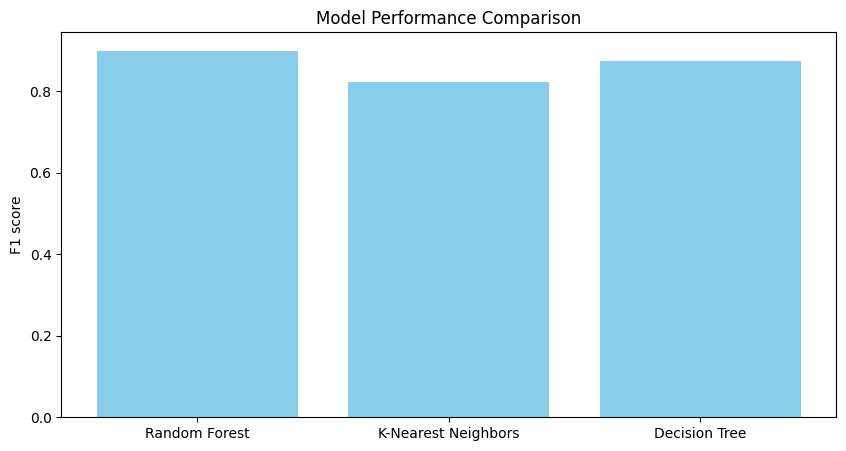

In [12]:
# Khởi tạo và huấn luyện các mô hình
models = {
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5),
    "Decision Tree": DecisionTreeClassifier(random_state=42)
}
results = []
# Huấn luyện và đánh giá các mô hình
for model_name, model in models.items():
    # Perform cross-validation
    scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
    # Train the model on the training data
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)  
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    # Calculate F1 score (weighted)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"Model: {model_name}, Accuracy: {accuracy:.6f}, F1 score: {scores.mean():.6f}")
    results.append({'Algorithm': model_name, 'Accuracy Score': accuracy, 'F1 Score': f1})

# Chuyển kết quả sang DataFrame
results_df = pd.DataFrame(results)

# Hiển thị bảng kết quả
print(results_df)

# Vẽ biểu đồ độ chính xác
plt.figure(figsize=(10, 5))
plt.bar(results_df['Algorithm'], results_df['F1 Score'], color='skyblue')
plt.title('Model Performance Comparison')
plt.ylabel('F1 score')
plt.show()

### Tối ưu hóa tham số mô hình Random Forest (RF)

In [13]:
# from sklearn.model_selection import RandomizedSearchCV

# param_grid = {'n_estimators': [50, 100, 200, 300, 400],
#               'max_depth': [None, 10, 20, 30, 40, 50],
#               'max_features': ['sqrt', 'log2'],
#               'min_samples_split': [2, 5, 10],
#               'min_samples_leaf': [1, 2, 4],
#               'bootstrap': [True, False],
#               'criterion': ['gini', 'entropy']
#              }
# grid_search = RandomizedSearchCV (RandomForestClassifier(), param_grid, n_iter=100, cv=5, scoring='f1_weighted')
# grid_search.fit(X_train, y_train)
# print("Best parameters: ", grid_search.best_params_)

In [14]:
# from sklearn.ensemble import RandomForestClassifier

# # Khởi tạo mô hình với các siêu tham số tốt nhất
# best_params = {'n_estimators': 300,
#                'min_samples_split': 5,
#                'min_samples_leaf': 1,
#                'max_features': 'log2',
#                'max_depth': 50,
#                'criterion': 'gini',
#                'bootstrap': False}

# model = RandomForestClassifier(**best_params)

# # Huấn luyện mô hình
# model.fit(X_train, y_train)

# # Dự đoán trên tập kiểm tra
# y_pred = model.predict(X_test)

# # Đánh giá mô hình
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='weighted')

# print(f"Accuracy: {accuracy} F1 Score: {f1}")

### Lưu mô hình

In [15]:
# import joblib

# model_filename = 'randomforest_model.pkl'

# # Lưu mô hình
# joblib.dump(model, model_filename)

# print(f"Mô hình đã được lưu thành công tại {model_filename}")

### Tải mô hình

In [16]:
# # Tải mô hình đã lưu
# loaded_model = joblib.load(model_filename)

# # Sử dụng mô hình để dự đoán
# y_pred = loaded_model.predict(X_test)

# print("Mô hình đã được tải và sẵn sàng sử dụng.")

In [17]:
# # Tính accuracy
# accuracy = accuracy_score(y_test, y_pred)
# f1 = f1_score(y_test, y_pred, average='weighted')
# print(f"               Algorithm  Accuracy Score  F1 Score")
# print(f"Random Forest Classifier        {accuracy:.6f}  {f1:.6f}")


### Ma trận nhầm lẫn

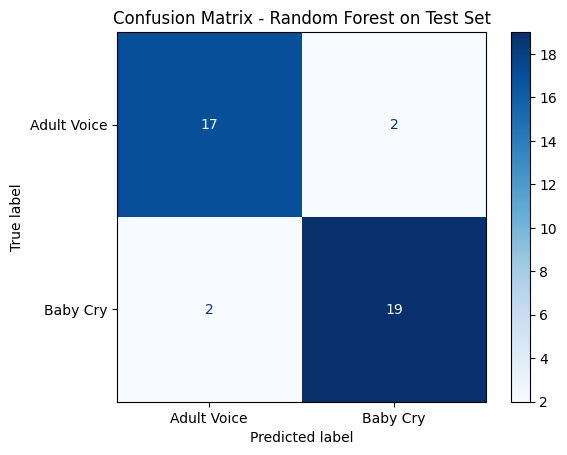

In [18]:
# Huấn luyện mô hình Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Dự đoán và hiển thị ma trận nhầm lẫn trên tập kiểm tra
y_pred = rf_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Adult Voice', 'Baby Cry'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - Random Forest on Test Set")
plt.show()

In [19]:
testing_dir = 'testing'

def test_model(directory, model):
    test_features = []
    test_files = []
    for filename in os.listdir(directory):
        if filename.endswith('.wav'):
            filepath = os.path.join(directory, filename)
            y, sr = librosa.load(filepath, sr=None)
            y = normalize_audio_length(y, sr)
            features = extract_features(y, sr)
            test_features.append(features)
            test_files.append(filename)
    
    test_features = np.array(test_features)
    predictions = model.predict(test_features)
    
    # Hiển thị kết quả dự đoán
    for file, pred in zip(test_files, predictions):
        label = "Baby Cry" if pred == 1 else "Adult Voice"
        print(f"File: {file}, Predicted Label: {label}")

# Kiểm thử mô hình
test_model(testing_dir, rf_model)

File: bbcry.wav, Predicted Label: Baby Cry
File: bbcry1.wav, Predicted Label: Baby Cry
File: bbcry2.wav, Predicted Label: Baby Cry
File: bbcry3.wav, Predicted Label: Baby Cry
File: bbcry4.wav, Predicted Label: Baby Cry
File: bbcry5.wav, Predicted Label: Baby Cry
File: FHU_RE_005.wav, Predicted Label: Adult Voice
File: lab_female.wav, Predicted Label: Adult Voice
File: lab_male.wav, Predicted Label: Adult Voice
File: male1.wav, Predicted Label: Adult Voice
File: male2.wav, Predicted Label: Adult Voice
File: male3.wav, Predicted Label: Adult Voice
File: MDU_RE_005.wav, Predicted Label: Adult Voice
File: studio_female.wav, Predicted Label: Adult Voice
File: studio_male.wav, Predicted Label: Adult Voice
